In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#Load the Dataset
mat_file_path = r"C:\Users\vmmba\OneDrive\Documents\FineTuneModel\wiki.mat"  # Update with the correct path
data = loadmat(mat_file_path)

In [3]:
# Extract relevant fields from the dataset
wiki_data = data['wiki'][0, 0]
dob = wiki_data['dob'][0]  # Date of birth
photo_taken = wiki_data['photo_taken'][0]  # Year photo was taken
full_path = wiki_data['full_path'][0]  # Image paths
face_score = wiki_data['face_score'][0]  # Face detection confidence score

In [4]:
print(face_score)
dob

[4.30096239 2.6456395  4.32932883 ... 3.49430317       -inf 5.48691655]


array([723671, 703186, 711677, ..., 720620, 723893, 713846])

In [5]:
#Convert the MATLAB serial date number to Python datetime
def matlab_to_datetime(matlab_datenum):
    if matlab_datenum <= 0:
        raise ValueError("Invalid MATLAB date number.")
    matlab_datenum = int(matlab_datenum)
    origin = datetime(1, 1, 1) + timedelta(days=366)
    return origin + timedelta(days=matlab_datenum)

In [6]:
print(matlab_to_datetime(723671))

1983-05-08 00:00:00


In [7]:
# Calculate age
ages = []
image_paths = []
for i in range(len(dob)):
    try:
        if dob[i] > 0 and face_score[i] > 1.0:  #Filter invalid DOB and low face score
            dob_date = matlab_to_datetime(dob[i])
            age = photo_taken[i] - dob_date.year
            if 0 <= age <= 100:  # Filter unrealistic ages which doesn't above 100 and below 1
                ages.append(age)
                image_paths.append(full_path[i][0])
    except Exception as e:
        print(f"Skipping records {i}: {e}")

In [8]:
# Convert to a DataFrame
df = pd.DataFrame({'age': ages, 'image_path': image_paths})
print(f"Processed dataset size : {df.shape}")

Processed dataset size : (42934, 2)


In [9]:
#print(f"DOB range: min={np.min(dob)}, max={np.max(dob)}")\
# Data Splitting using train_test_split built in function
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


In [10]:
print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")


Train set size: (34347, 2)
Validation set size: (4293, 2)
Test set size: (4294, 2)


In [11]:
# Data Augmentation and Preprocessing
image_size = (128, 128)
batch_size = 32


In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [13]:
def create_generator(df, base_path, datagen, is_training=True):
    return datagen.flow_from_dataframe(
        df,
        directory=base_path,
        x_col='image_path',
        y_col='age',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=is_training
    )

In [14]:
# Specify the path to the image dataset
base_path = r"C:\Users\vmmba\OneDrive\Documents\FineTuneModel\images\wiki_crop"  # Update with the correct path

In [15]:
train_generator = create_generator(train_df, base_path, train_datagen, is_training=True)
val_generator = create_generator(val_df, base_path, val_datagen, is_training=False)

Found 34347 validated image filenames.
Found 4293 validated image filenames.


In [16]:
#Define a Custom CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(101, activation='softmax')  # Assuming age is categorized from 0 to 100
])

In [17]:
#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [18]:
# Train the Model
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    workers=18,  #Number of CPU cores to reduce the execution time
    use_multiprocessing=False,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5
1074/1074 [==============================] - 394s 364ms/step - loss: 4.0943 - accuracy: 0.0381 - val_loss: 3.9533 - val_accuracy: 0.0352
Epoch 2/5
1074/1074 [==============================] - 375s 348ms/step - loss: 3.9651 - accuracy: 0.0407 - val_loss: 3.8919 - val_accuracy: 0.0389
Epoch 3/5
1074/1074 [==============================] - 377s 350ms/step - loss: 3.9094 - accuracy: 0.0424 - val_loss: 3.8304 - val_accuracy: 0.0466
Epoch 4/5
1074/1074 [==============================] - 381s 353ms/step - loss: 3.8658 - accuracy: 0.0432 - val_loss: 3.7991 - val_accuracy: 0.0433
Epoch 5/5
1074/1074 [==============================] - 608s 565ms/step - loss: 3.8373 - accuracy: 0.0436 - val_loss: 3.7761 - val_accuracy: 0.0415


In [20]:
#Evaluate the Model
model.load_weights("best_model.h5")
test_generator = create_generator(test_df, base_path, val_datagen, is_training=False)
results = model.evaluate(test_generator)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Found 4294 validated image filenames.
135/135 [==============================] - 173s 1s/step - loss: 3.7573 - accuracy: 0.0482
Test Loss: 3.7572944164276123, Test Accuracy: 0.04820679873228073


In [21]:
#Generating Confusion Matrix and Classification Report
y_true = test_generator.labels
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

135/135 [==============================] - 118s 871ms/step


<Axes: >

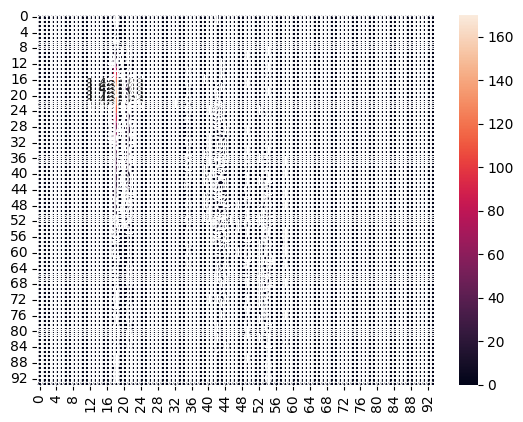

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix:\n", conf_matrix)
sns.heatmap(conf_matrix,annot=True)

In [23]:
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00        22
          16       0.00      0.00      0.00        55
          17       0.00      0.00      0.00        75
          18       0.00      0.00      0.00       101
          19       0.00      0.00      0.00       111
          20       0.00      0.00      0.00       141
   

C:\Users\vmmba\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmmba\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vmmba\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

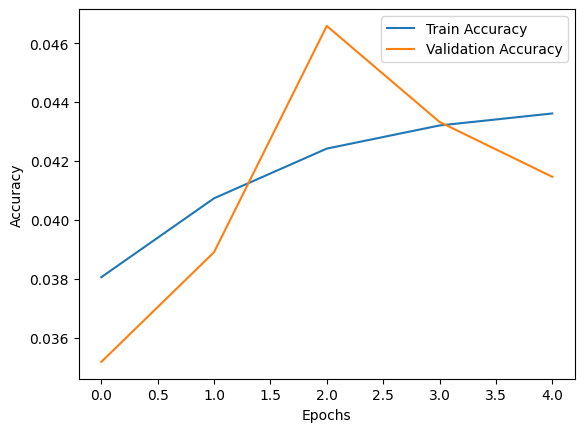

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

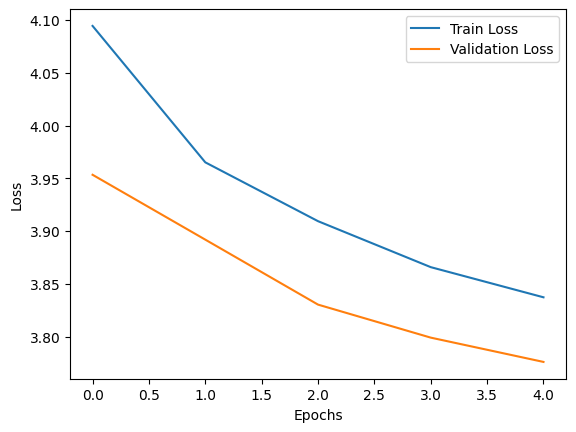

In [25]:
#Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
import cv2
#Test with some images
dataset_folder = r"C:\Users\vmmba\OneDrive\Documents\CelebFaceRecognition\images_dataset\lionel_messi"

# Check if the folder exists
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"The dataset folder '{dataset_folder}' does not exist. Please ensure it is downloaded and available.")

# List all image files in the folder
files = os.listdir(dataset_folder)

# Initialize empty lists for images
images = []

# Load and preprocess images
for file in files:
    file_path = os.path.join(dataset_folder, file)
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (48, 48))  # Resize to the required input shape
        images.append(image)

# Convert to numpy array
images_f = np.array(images)

# Normalize the images for model input
images_f_2 = images_f / 255.0

print(f"Loaded {len(images_f)} images successfully.")

Loaded 58 images successfully.


In [92]:
import os
import cv2
import numpy as np

# Test with some images
dataset_folder = r"C:\Users\vmmba\OneDrive\Documents\CelebFaceRecognition\images_dataset\lionel_messi"

# Check if the folder exists
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"The dataset folder '{dataset_folder}' does not exist. Please ensure it is downloaded and available.")

# List all image files in the folder
files = os.listdir(dataset_folder)

# Initialize empty lists for original and preprocessed images
original_images = []
processed_images = []

# Load and preprocess images
for file in files:
    file_path = os.path.join(dataset_folder, file)
    image = cv2.imread(file_path)
    if image is not None:
        # Resize original images to a consistent resolution for display (e.g., 128x128)
        original_image_resized = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image_resized = cv2.resize(original_image_resized, (128, 128))
        original_images.append(original_image_resized)

        # Resize and preprocess for model input
        resized_image = cv2.resize(image, (48, 48))  # Resize to model input shape
        processed_images.append(resized_image)

# Convert to numpy arrays
images_f = np.array(original_images)  # Original images resized for display
images_f_2 = np.array(processed_images) / 255.0  # Normalized images for model input

print(f"Loaded {len(images_f)} images successfully.")


Loaded 58 images successfully.


In [85]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_random_samples(model, images, images_normalized, num_samples=5):
    # Randomly select sample indices
    sample_indices = random.sample(range(len(images)), num_samples)
    
    for idx in sample_indices:
        # Display the image
        plt.imshow(images[idx])
        plt.axis('off')
        plt.show()

        # Normalize and predict
        normalized_image = images_normalized[idx]
        prediction = model.predict(np.expand_dims(normalized_image, axis=0))

        # Interpret the prediction (softmax output)
        predicted_age = np.argmax(prediction[0])  # Index of the max probability

        # Print predictions
        print(f"Predicted Age: {predicted_age}")



In [93]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_random_samples(model, images, images_normalized, num_samples=5):
    # Randomly select sample indices
    sample_indices = random.sample(range(len(images)), num_samples)
    
    for idx in sample_indices:
        # Extract the original image
        original_image = images[idx]
        
        # Display the image with better clarity
        plt.figure(figsize=(6, 6))  # Adjust figure size for better clarity
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if needed
        plt.axis('off')
        plt.show()

        # Normalize and predict
        normalized_image = images_normalized[idx]
        prediction = model.predict(np.expand_dims(normalized_image, axis=0))

        # Interpret the prediction (softmax output)
        predicted_age = np.argmax(prediction[0])  # Index of the max probability

        # Print predictions
        print(f"Predicted Age: {predicted_age}")


In [94]:
def resize_images(images, target_size=(128, 128)):
    resized_images = [cv2.resize(img, target_size,interpolation=cv2.INTER_AREA) for img in images]
    return np.array(resized_images)

# Resize the dataset
images_resized = resize_images(images_f_2)
images_normalized = images_resized / 255.0


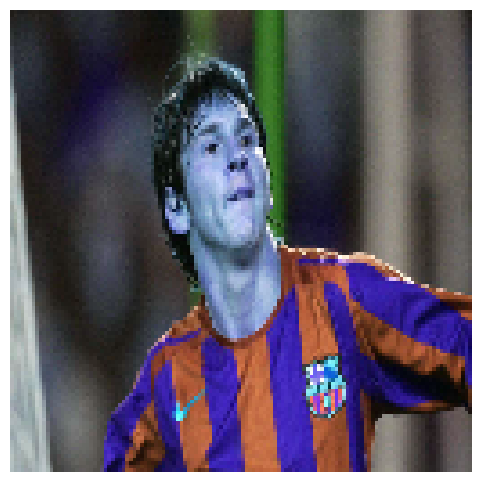

1/1 [==============================] - 0s 50ms/step
Predicted Age: 22


In [99]:
predict_random_samples(model, images_f, images_normalized, num_samples=1)